Введите количество узлов: 20491
x:         0.000000E+00 1.000000E-01 2.000000E-01 3.000000E-01 4.000000E-01 5.000000E-01 6.000000E-01 7.000000E-01 8.000000E-01 9.000000E-01 1.000000E+00
u_analit:  1.000000E+00 1.099259E+00 1.194275E+00 1.285403E+00 1.372983E+00 1.458840E+00 1.551252E+00 1.651497E+00 1.759648E+00 1.875787E+00 2.000000E+00
u_m_comp:  1.000000E+00 1.099264E+00 1.194286E+00 1.285419E+00 1.373005E+00 1.458825E+00 1.551241E+00 1.651488E+00 1.759642E+00 1.875784E+00 2.000000E+00
diff:      0.000000E+00 5.520102E-06 1.106125E-05 1.664417E-05 2.228973E-05 1.466478E-05 1.171693E-05 8.778669E-06 5.847846E-06 2.922330E-06 0.000000E+00
max diff:  2.228973E-05
u_comp:    1.000000E+00 1.131916E+00 1.252626E+00 1.361787E+00 1.459901E+00 1.549482E+00 1.638597E+00 1.727722E+00 1.816928E+00 1.907093E+00 2.000000E+00


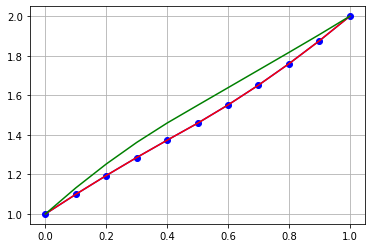

In [27]:
from numpy import sin, cos, exp, sqrt, linspace, array
import matplotlib.pyplot as plt
import csv

'''
This programm solve heat equation with break point
d/dx*[k(x)*du/dx]-q*u=-f
u(0) = u0
u(1) = u1
0 <= x <= 1
x0 - break point
u(x0-0) = u(x0+0)
k(x)*du(x0-0)/dx = k(x)*du(x0+0)/dx


For solution are used 
'''

# initial params of problem
x0 = 1/sqrt(5)
u0 = 1
u1 = 2

# compute and return constants for analytical model solution
def cs(l1, l2):
    a11 = exp(-l1*x0)-exp(l1*x0)
    a12 = exp(l2*(2-x0))-exp(l2*x0)
    a21 = ka(x0)*l1*(exp(l1*x0)+exp(-l1*x0))
    a22 = kb(x0)*l2*(exp(l2*(2-x0))+exp(l2*x0))
    ma = fa(x0)/qa(x0)
    mb = fb(x0)/qb(x0)
    b1 = mb-ma+(ma-u0)*exp(l1*x0)-(mb-u1)*exp(l2*(1-x0))
    b2 = ka(x0)*l1*(u0-ma)*exp(l1*x0)+kb(x0)*l2*(u1-mb)*exp(l2*(1-x0))
    c1 = (((u0-ma)*a11-b1)*a22-((u0-ma)*a21-b2)*a12)/(a11*a22-a12*a21)
    c2 = (b1*a22-b2*a12)/(a11*a22-a12*a21)
    c3 = (b2*a11-b1*a21)/(a11*a22-a12*a21)
    c4 = (u1-mb)*exp(l2)-c3*exp(2*l2)
    return c1, c2, c3, c4


# compute and return analytical model u in point x
def model_u(x, l_1, l_2, c_1, c_2, c_3, c_4):
    if x < x0:
        c1 = c_1
        c2 = c_2
        m = fa(x0)/qa(x0)
        l1 = l_1
    else:
        c1 = c_3
        c2 = c_4
        m = fb(x0)/qb(x0)
        l1 = l_2
    return c1 * exp(l1 * x) + c2 * exp(-l1 * x) + m


# k for i < la
def ka(x):
    return sin(x**2)+1


# k for i > lb
def kb(x):
    return sin(x**2)+1


# q for i < la
def qa(x):
    return x


# q for i > lb
def qb(x):
    return x**3


# f for i < la
def fa(x):
    return 1

# f for i > lb
def fb(x):
    return x**2-1

'''
Solve three diagonal matrix for break point problem
Get four one-dimensional arrays that creates system of equations like
'''
def counter_sweep_method(a, b, c, d, la, lb):
    n = len(a)
    alpha = [0] * (n-1)
    alpha[1] = -a[1]/b[1]
    alpha[-1] = -c[-1]/b[-1]
    beta = [0] * (n-1)
    beta[1] = (d[1]-c[1]*u0)/b[1]
    beta[-1] = (d[-1]-c[-1]*u1)/b[-1]
    x = [u0] * n
    x[-1] = u1
    for i in range(2, la):
        alpha[i] = (-a[i]/(c[i]*alpha[i-1]+b[i]))
        beta[i] = ((d[i]-c[i]*beta[i-1])/(b[i]+c[i]*alpha[i-1]))
    for i in reversed(range(lb+1, n-2)):
        alpha[i] = -c[i]/(b[i]+a[i]*alpha[i+1])
        beta[i] = (d[i]-a[i]*beta[i+1])/(b[i]+a[i]*alpha[i+1])
    x[lb] = x[la] = (ka(x0)*beta[la-1]+kb(x0)*beta[lb+1])/(ka(x0)*(1-alpha[la-1])+kb(x0)*(1-alpha[lb+1]))
    for i in reversed(range(1, la)):
        x[i] = alpha[i]*x[i+1]+beta[i]
    for i in range(lb+1, n-1):
        x[i] = alpha[i]*x[i-1]+beta[i]
    return x


def init_const_abcd(n):
    a, b, c, d = [], [], [], []
    for i in range(n):
        a.append(ka(x0) if i < la else kb(x0))
        b.append(-2 * ka(x0) - qa(x0) * h ** 2 if i < la else -2 * kb(x0) - qb(x0) * h ** 2)
        c.append(ka(x0) if i < la else kb(x0))
        d.append(-fa(x0) * h ** 2 if i < la else -fb(x0) * h ** 2)
    return a, b, c, d


def init_variable_abcd(n):
    a, b, c, d = [], [], [], []
    for i in range(n):
        a.append(ka(h * (i + 1. / 2)) if i < la else kb(h * (i + 1. / 2)))
        b.append(-(ka(h * (i + 1. / 2)) + ka(h * (i - 1. / 2)) + qa(h * i) * h ** 2) if i < la else -(
        kb(h * (i + 1. / 2)) + kb(h * (i - 1. / 2)) + qb(h * i) * h ** 2))
        c.append(ka(h * (i - 1. / 2)) if i < la else kb(h * (i - 1. / 2)))
        d.append(-fa(h * i) * h ** 2 if i < la else -fb(h * i) * h ** 2)
    return a, b, c, d


def u_model_comp(n):
    a, b, c, d = init_const_abcd(n)
    x = counter_sweep_method(a, b, c, d, la, lb)
    return [x[int(i*(n-1)/10)] for i in range(11)]


def u_var_comp(n):
    a, b, c, d = init_variable_abcd(n)
    x = counter_sweep_method(a, b, c, d, la, lb)
    return [x[int(i*(n-1)/10)] for i in range(11)]


slot = [0, 1]
rep_x = linspace(slot[0], slot[1], 11)
n = int(input('Введите количество узлов: '))
h = (slot[1] - slot[0]) / (n-1)

print("x:        ", " ".join("%.6E" % x for x in rep_x))
l1 = sqrt(qa(x0)/ka(x0))
l2 = sqrt(qb(x0)/kb(x0))
c1, c2, c3, c4 = cs(l1, l2)

u_model_analit = [model_u(x, l1, l2, c1, c2, c3, c4) for x in rep_x]
print("u_analit: ", " ".join("%.6E" % i for i in u_model_analit))
la = int(x0/h)
lb = la+1
plt.plot(rep_x, u_model_analit, '-o', color="blue")

u_model_c = u_model_comp(n)
plt.plot(rep_x, u_model_c, color="red")
print("u_m_comp: ", " ".join("%.6E" % i for i in u_model_c))

diff = [abs(i-j) for i,j in zip(u_model_analit, u_model_c)]
max_diff = max(abs(i-j) for i,j in zip(u_model_analit, u_model_c))

print("diff:     ", " ".join("%.6E" % i for i in diff))
print("max diff: ", "%.6E" % max_diff)

xs = u_var_comp(n)
plt.plot(rep_x, xs, color="green")
print("u_comp:   ", " ".join("%.6E" % i for i in xs))
plt.grid()
plt.show()

In [25]:
with open('answer.csv', mode='w') as file:
    
    names = ['x', 'u_analit', 'u_m_comp', 'diff', 'max_diff', 'u_comp']
    
    writer = csv.writer(file, delimiter=',')
    writer.writerow(names)
    
    for i in range(len(rep_x)):
        writer.writerow(array([rep_x[i], u_model_analit[i], u_model_c[i], diff[i], max_diff, xs[i]]).round(10))